#  Differential Equations

In [1]:
using PyPlot, PyCall

## Overview

Differential equations arise in the mathematical modeling of a wide range of problems, ranging from science and engineering to economics and finance. Here we will consider *Ordinary Differential Equations* (ODEs), where the unknown function $y(t)$ depends on a single independent variable $t$.

## Initial value problems

An *initial value problem* (IVP) can be written as:

$$
\begin{align*}
y'(t) &= f(t,y(t)), \quad t\ge t_0 \\
y(t_0) &= y_0
\end{align*}
$$

for some *right-hand side function* $f(t,y)$ and *initial condition* $y_0$ for $t=t_0$. In these problems, the independent variable $t$ often represents time.

Sometimes basic calculus can be used to solve these equations. For example, some *linear* and *separable* equations have closed-form solutions. But in general we have to resort to *numerical methods* to find approximations to the solution $y(t)$.

### Euler's method

The most basic approach for numerically solving an IVP is *Euler's method*, illustrated below.

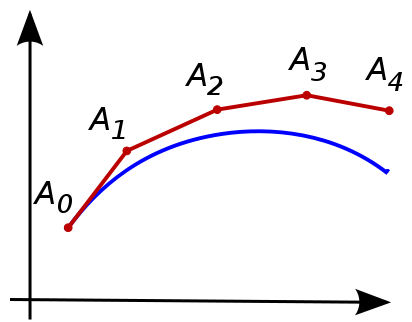
(from Wikipedia, <https://en.wikipedia.org/wiki/Euler_method>).

We first choose a *step size*, or *time step*, $h$, and define the discrete times $t_n = t_0 + nh$, $n = 0,1,\ldots$. Euler's method advances the solution $y_n$ at time $t_n$ to time $t_{n+1}$ by a linear approximation using the derivative at time $t_n$:

$$
y_{n+1} = y_n + hf(t_n,y_n)
$$

With some assumptions on the IVP and the step size, these values can be shown to be good approximation to the true solution, that is, $y_n \approx y(t_n$).

While described for scalar-valued functions $y(t)$, the method works equally well for systems of equations, that is, when $y(t)$ and $f(t,y(t))$ are vector-valued.

### Euler's method, implementation

We implement a general version of Euler's method which takes the right-hand side function $f(t,y(t))$
as an argument. In addition, it takes the initial condition $y_0$, the step size $h$, the number of steps $N$, and the starting time $t_0$ which has a default value of $0$. Note that the implementations supports solutions $y$ that are vector-valued, and the output `y` is a 2D array of the approximate solutions at each time step.

In [2]:
function euler(f, y0, h, N, t0=0.0)
    t = t0 .+ h*(0:N)
    y = zeros(length(y0), N+1)
    
    y[:,1] .= y0
    for n = 1:N
        y[:,n+1] = y[:,n] + h * f(t[n], y[:,n])
    end
    
    return t,y
end

euler (generic function with 2 methods)

We demonstrate the method on a model problem with $f(t,y) = -y + \sin t$ and $y(0) = 1$. We solve using Euler's method with time step $h=0.2$ and $N=20$ steps.

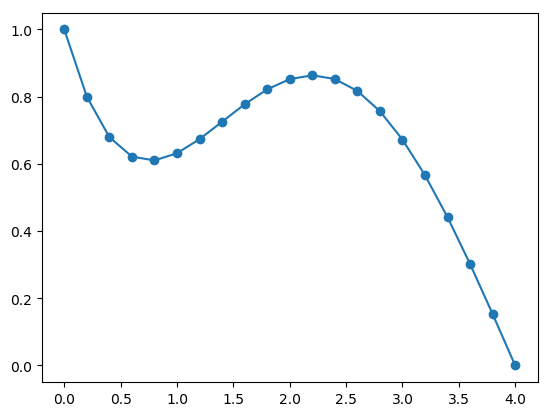

In [3]:
f(t,y) = -y .+ sin(t)
t,y = euler(f, 1, 0.2, 20)
plot(t, y[:], "-o");

We can compare the results to the exact solution:

$$
y_\mathrm{exact} = e^{-t} + (\sin t - \cos t + e^{-t}) / 2
$$

In the code below, we solve three times using various time steps $h$. In the plot, we see that the results are generally better for smaller $h$ (as expected), and the accuracy seems to roughly scale linearly with $h$. This can be shown to be true in general: the method is *convergent* (the approximations approach the exact solution as $h \rightarrow 0$), and the method is first-order accurate (the error scales with the first power of $h$).

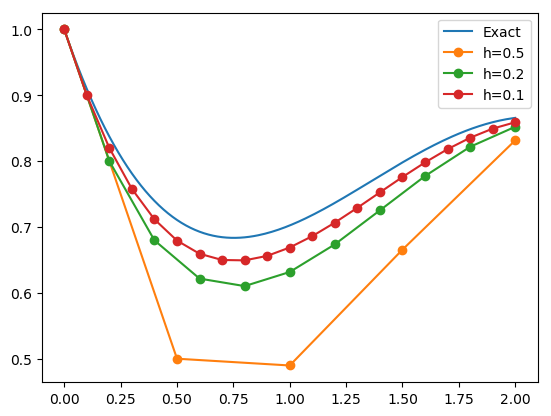

In [4]:
yexact(t) = exp(-t) + (sin(t) - cos(t) + exp(-t)) / 2
tt = 0:0.01:2
plot(tt, yexact.(tt))
for h = [0.5, 0.2, 0.1]
    t,y = euler(f, 1, h, round(Int, 2/h))
    plot(t, y[:], "-o")
end
legend(("Exact", "h=0.5", "h=0.2", "h=0.1"));

### The Runge-Kutta method

While Euler's method does give accurate results for small enough time steps $h$, its first-order convergence is often considered too slow and much better methods have been developed. One of the most popular methods is the following 4th order accurate Runge-Kutta method (RK4):

$$
\begin{align*}
k_1 &= h f(t_n, y_n) \\
k_2 &= h f(t_n + h/2, y_n + k_1/2) \\
k_3 &= h f(t_n + h/2, y_n + k_2/2) \\
k_4 &= h f(t_n + h, y_n + k_3) \\
y_{n+1} &= y_n + (k_1 + 2k_2 + 2k_3 + k_4) / 6
\end{align*}
$$

We implement it in a very similar way to before. Note that each step now requires computing the four so-called *stages* or *stage derivatives* $k_1,k_2,k_3,k_4$.

In [5]:
function rk4(f, y0, h, N, t0=0)
    t = t0 .+ h*(0:N)
    y = zeros(length(y0), N+1)
    
    y[:,1] .= y0
    for n = 1:N
        k1 = h * f(t[n], y[:,n])
        k2 = h * f(t[n] + h/2, y[:,n] + k1/2)
        k3 = h * f(t[n] + h/2, y[:,n] + k2/2)
        k4 = h * f(t[n] + h, y[:,n] + k3)
        y[:,n+1] = y[:,n] + (k1 + 2k2 + 2k3 + k4) / 6
    end
    
    return t,y
end

rk4 (generic function with 2 methods)

Run the same test problem as before using RK4:

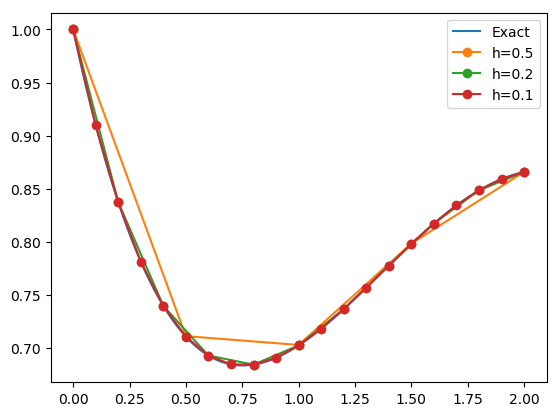

In [6]:
yexact(t) = exp(-t) + (sin(t) - cos(t) + exp(-t)) / 2
tt = 0:0.01:2
plot(tt, yexact.(tt))
for h = [0.5, 0.2, 0.1]
    t,y = rk4(f, 1, h, round(Int, 2/h))
    plot(t, y[:], "-o")
end
legend(("Exact", "h=0.5", "h=0.2", "h=0.1"));

We can see that the results are fundamentally more accurate. In fact, even with largest time step $h=0.5$, the point values are essentially right on top of the exact solution. We can compute the error for the smallest time step $h=0.1$, and note that it has 6 accurate digits:

In [7]:
errors = @. y[:] - yexact(t[:])
max_error = maximum(abs.(errors))

5.015261516083669e-7

## Higher-order derivatives, systems of ODEs

Our implementation of RK4 supports systems of ODEs, that is, problems with vector-valued solutions $y(t)$. This can also be used to solve scalar-valued equations with higher-order derivatives. Consider e.g. the motion of a pendulum, with an angle $\theta$ from the vertical axis and normalized physical constants:

$$
\theta''(t) + \sin \theta(t) = 0
$$

To write this as a system of first-order equations, we introduce the first derivative $\theta'(t)$ as a new unknown and solve for the vector-valued function $y(t) = (\theta(t), \theta'(t))$. The corresponding right-hand side in the system of equations then becomes

$$
y'(t) = f(t, y(t)) =
\begin{pmatrix}
\theta'(t) \\
-\sin \theta(t)
\end{pmatrix}
$$

This is implemented below, and solved for an initial condition $y(0) = (\theta(0), \theta'(0)) = (2.5,0)$ using a step size of $h=0.1$ up to time $T=10$:

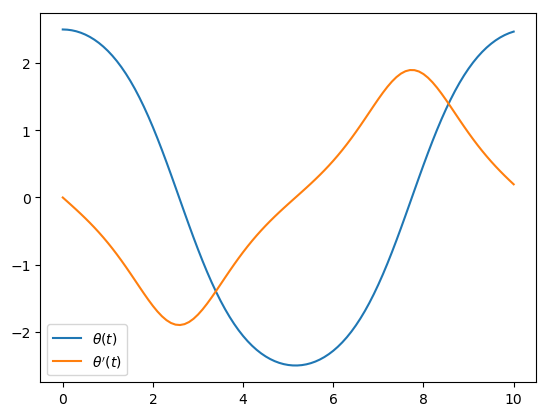

In [8]:
f(t,y) = [y[2], -sin(y[1])]
y0 = [2.5, 0]
h = 0.1
T = 10
t,y = rk4(f, y0, h, round(Int, T/h))
plot(t,collect(y'))
legend(("\$\\theta(t)\$", "\$\\theta'(t)\$"));

The motion of the pendulum can also be animated:

In [9]:
animation = pyimport("matplotlib.animation");
fig, ax = subplots(figsize=(5,5))
function update(frame)
    θ = y[1,frame+1]
    ax[:clear]()
    ax[:plot]([0,sin(θ)], [0,-cos(θ)], linewidth=2)
    ax[:add_artist](matplotlib[:patches][:Circle]([sin(θ),-cos(θ)], 0.1))
    ax[:set_xlim]([-1.5,1.5])
    ax[:set_ylim]([-1.5,1.5])
end
ani = animation[:FuncAnimation](fig, update, frames=length(t), interval=50)
close(ani[:_fig])
@pyimport IPython.display as d
d.HTML(ani[:to_jshtml]())

PyObject <IPython.core.display.HTML object>

## Boundary value problems

Another class of ODEs are *boundary value problems* (BVPs), where conditions on the solution are given at two different values for the independent variable (instead of at only an initial time, as for the IVPs). In these problems the independent variable is often a spatial coordinate, so we denote it by $x$. A model BVP problem is the Poisson equation with Dirichlet conditions at the endpoints, for example:

$$
\begin{align*}
u''(x) &= f(x), \quad 0<x<1 \\
u(0) &= \alpha \\
u(1) &= \beta
\end{align*}
$$

This problem can be solved using finite differences. Introduce $n+2$ points between 0 and 1, a grid spacing $h = 1/(n+1)$ and a corresponding grid of points $x_j = jh$, $j=0,1,\ldots,n+1$. At each of these grid points, we will approximate the solution numerically, that is, $u_j \approx u(x_j)$. To impose the differential equations, we need to estimate the second derivative $u''(x)$ at each grid point. We can do this using finite difference approximations, for example the second-order accurate formula

$$
u''(x_j) \approx \frac{1}{h^2}(u_{j+1} - 2u_j + u_{j-1})
$$

Using this we can approximate the differential equation at all interior points:

$$
u_{j+1} - 2u_j + u_{j-1} = h^2 f(x_j), \quad j = 1,\ldots, n
$$

The boundary values are simply imposed by setting $u_0 = \alpha$ and $u_{n+1} = \beta$. This leads to a tridiagonal linear system of equations $Au=b$ where

$$
A=
\begin{bmatrix}
-2 & 1 & &  \\
1 & -2 & 1  & \\
  & & \ddots  & \\
  & & 1 & -2
\end{bmatrix}
\quad u=
\begin{bmatrix}
u_1 \\ u_2 \\ \vdots \\ u_n
\end{bmatrix}
\quad b=
\begin{bmatrix}
h^2f(x_1) - \alpha \\
h^2f(x_2) \\
\vdots \\
h^2f(x_n)-\beta
\end{bmatrix}
$$

### Example BVP

For example we consider the boundary value problem


$$
\begin{align*}
u''(x) &= 10e^{2x}\sin(2\pi x), \quad 0<x<1 \\
u(0) &= -1 \\
u(1) &= 1
\end{align*}
$$

We use a grid with $n=49$ interior points (50 intervals).

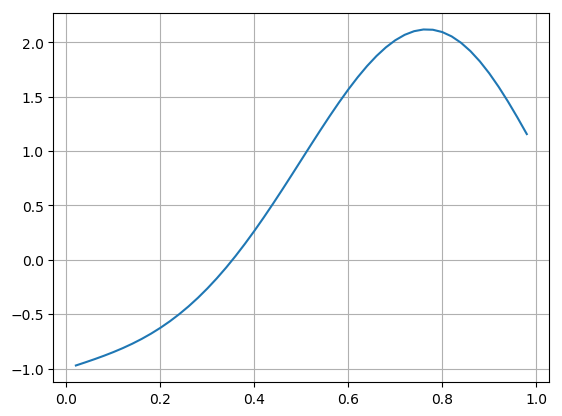

In [10]:
using LinearAlgebra

n = 49
h = 1 / (n+1)
x = h*(1:n)
f(x) = 10exp(2x)*sin(2π*x)

A = SymTridiagonal(-2ones(n), ones(n))
b = h^2*f.(x)
b[1] -= -1
b[end] -= 1
u = A \ b

plot(x, u)
grid(true)

## The DifferentialEquations package

Various ODE solvers are implemented in the excellent `DifferentialEquations` package. They are similar to our `euler` and `rk4` functions above in the sense that they accept input arguments that define the problem as well as numerical parameters. But a major difference is that they use automatic step control. Instead of defining time steps $h$, you specify absolute and relative tolerances (`abstol` and `reltol`). If needed, the solution can be interpolated to arbitrary time values. 

We demonstrate the package using the pendulum problem from above. The definition of the right-hand side is similar to before, except the order of the arguements is different and it also accepts an argument `p` with (optional) paramters. The initial condition is again simply a vector of values.

In [11]:
using DifferentialEquations
f(y,p,t) = [y[2], -sin(y[1])]
y0 = [2.5, 0]

2-element Array{Float64,1}:
 2.5
 0.0

Next we specify the initial time $t_0$ and the final time $T$ as a tuple of two values. Note again that we do not set any time steps, only the interval of the solution:

In [12]:
tspan = (0.0, 10.0)

(0.0, 10.0)

Now we can create a so-called `ODEProblem` and solve using specified accuracy tolerances:

In [13]:
prob = ODEProblem(f, y0, tspan)
sol = solve(prob, abstol=1e-8, reltol=1e-8);

The resulting solution variable `sol` can now be viewed in various ways. For example, the actual numerical time steps are available in the array `sol.t`, and the corresponding solution values in the array `sol.u`:

In [14]:
display(hcat(sol.t, collect(sol.u)))

51×2 Array{Any,2}:
  0.0        [2.5, 0.0]           
  0.0421484  [2.49947, -0.0252307]
  0.151258   [2.49314, -0.0908002]
  0.297368   [2.47338, -0.180062] 
  0.458322   [2.43626, -0.281938] 
  0.645055   [2.37206, -0.407204] 
  0.847126   [2.27514, -0.55427]  
  1.05525    [2.14272, -0.720958] 
  1.26012    [1.97682, -0.901315] 
  1.4608     [1.777, -1.09215]    
  1.65596    [1.54501, -1.28602]  
  1.84709    [1.28108, -1.47433]  
  2.03723    [0.984059, -1.64608] 
  ⋮                               
  7.90216    [0.301992, 1.87397]  
  8.08319    [0.634659, 1.79244]  
  8.26647    [0.951861, 1.66211]  
  8.46036    [1.25781, 1.48933]   
  8.67917    [1.56033, 1.27406]   
  8.86472    [1.77957, 1.08984]   
  9.06404    [1.97772, 0.900399]  
  9.26138    [2.138, 0.726457]    
  9.47042    [2.27202, 0.558553]  
  9.6894     [2.37661, 0.399368]  
  9.92389    [2.45179, 0.244016]  
 10.0        [2.46853, 0.196093]  

But in practice it is more likely that you want to evaluate the numerical solution at arbitrary times. The differential equation package allows you to *interpolate* by simply using the `sol` variable as a function:

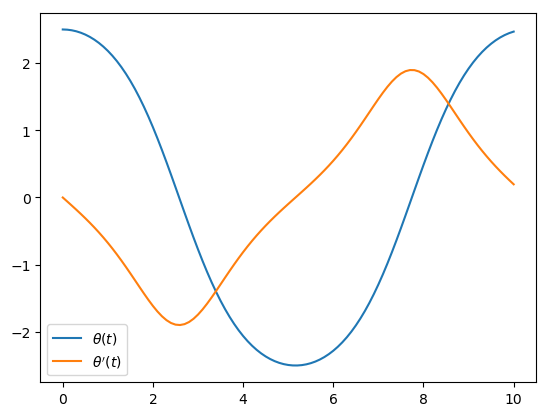

In [15]:
tt = 0:0.1:10
plot(t, sol.(t));
legend(("\$\\theta(t)\$", "\$\\theta'(t)\$"));

### Continuous events

Another important feature in the differential equation package is the support for *events*. These can be used to e.g. change the solution when certain conditions are satisfied, or to end the simulation.

As an example, suppose we want to find the period of the pendulum from before. This is a non-trivial problem, but numerically we can find it by telling the ODE solver to stop when $\theta'(t)=0$. This will give the (first) time instance that the pendulum turns, which corresponds to half the period.

A so-called *continuous event* is specified as a condition, and the event will be triggered when the condition is zero. In our case, the condition is simply $\theta'$, or the second component or our solution vector:

In [16]:
condition(y, t, integrator) = y[2]

condition (generic function with 1 method)

Next we specify when the solver should do when the condition is satisfied. We want to stop the simulation, which can be done with the `terminate!` function:

In [17]:
affect!(integrator) = terminate!(integrator)

affect! (generic function with 1 method)

Finally we define a so-called `ContinuousCallback` and pass it to the solve, and obtain the half period as the final time instance:

In [18]:
cb = ContinuousCallback(condition, affect!)
sol = solve(prob, callback=cb, abstol=1e-8, reltol=1e-8)
println("Period = $(2sol.t[end])")

Period = 10.323162865454941
